try spectral clustering

In [ ]:
#weights and bias connect
import os
import wandb
from getpass import getpass
!pip install wandb
from google.colab import userdata
userdata.get('WandB')
WANDB_PROJECT='Georgia-Frog-Identification'
WANDB_ENTITY='hikesofgeorgia-hikes-of-georgia-llc'

os.environ["WANDB_API_KEY"] = getpass("Enter your W&B API key: ")
wandb.login()

Enter your W&B API key: ··········


True

In [ ]:
import os

directory_path = '/content/drive/MyDrive/spectrograms'
if os.path.isdir(directory_path):
    print("Contents of the directory:")
    for item in os.listdir(directory_path):
        print(item)
else:
    print(f"Error: {directory_path} is not a valid directory.")

Contents of the directory:
american_bullfrog
american_toad
bird_voiced_tree_frog
copes_gray_treefrog
eastern_spadefoot_toad
eastern_narrow_mouthed_toad
green_frog
fowlers_toad
green_tree_frog
northern_cricket_frog
not_frogs
pickerel_frog
preview
spring_peeper
upland_chorus_frog
southern_leopard_frog


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os
import numpy as np # Import numpy
import torch.nn.functional as F # Import functional for tensor transforms

class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the class subdirectories.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        self.classes = sorted([d.name for d in os.scandir(root_dir) if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                # Check for .npy file extension
                if filename.endswith('.npy'):
                    self.image_files.append(os.path.join(class_dir, filename))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_files[idx]
        # Load .npy file using numpy
        spectrogram = np.load(img_path)

        # Convert numpy array to torch tensor. Assuming the shape is (height, width)
        # and needs to be (channels, height, width) and data type is float32
        image = torch.from_numpy(spectrogram).unsqueeze(0).float()


        label = self.labels[idx]

        if self.transform:
            # Apply transforms that work on tensors
            image = self.transform(image)

        return image, label

def normalize_tensor(tensor):
    """
    Normalize a tensor to have values between 0 and 1.
    """
    tensor_min = tensor.min()
    tensor_max = tensor.max()
    return (tensor - tensor_min) / (tensor_max - tensor_min + 1e-8)

def standardize_tensor(tensor):
    """
    Standardize a tensor to have zero mean and unit variance.
    """
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / (std + 1e-8)

def resize_tensor(tensor, size):
    """
    Resize a tensor to the specified size.
    """
    return F.interpolate(tensor.unsqueeze(0), size=size, mode='bilinear', align_corners=False).squeeze(0)

transform =  transforms.Compose([
    transforms.Lambda(lambda x: resize_tensor(x, (128, 128))),
    transforms.Lambda(lambda x: normalize_tensor(x)),
])

dataset = SpectrogramDataset(root_dir='/content/drive/MyDrive/spectrograms', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

Class Distribution:
  american_bullfrog: 123 samples (8.8%)
  american_toad: 183 samples (13.1%)
  bird_voiced_tree_frog: 27 samples (1.9%)
  copes_gray_treefrog: 137 samples (9.8%)
  eastern_narrow_mouthed_toad: 97 samples (6.9%)
  eastern_spadefoot_toad: 17 samples (1.2%)
  fowlers_toad: 40 samples (2.9%)
  green_frog: 84 samples (6.0%)
  green_tree_frog: 180 samples (12.9%)
  northern_cricket_frog: 164 samples (11.7%)
  not_frogs: 117 samples (8.4%)
  pickerel_frog: 57 samples (4.1%)
  preview: 0 samples (0.0%)
  southern_leopard_frog: 36 samples (2.6%)
  spring_peeper: 106 samples (7.6%)
  upland_chorus_frog: 32 samples (2.3%)


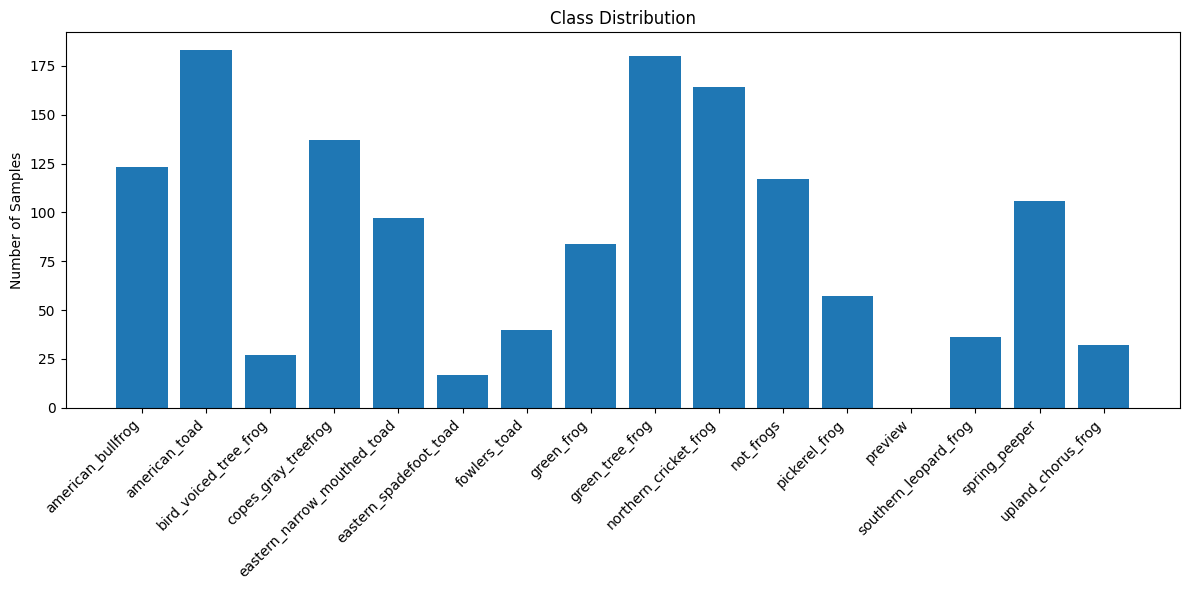

In [ ]:
import matplotlib.pyplot as plt
import collections

def analyze_class_distribution(dataset):
    """Analyze and visualize class distribution"""
    class_counts = collections.Counter(dataset.labels)
    class_names = dataset.classes

    print("Class Distribution:")
    for i, class_name in enumerate(class_names):
        count = class_counts[i]
        print(f"  {class_name}: {count} samples ({count/len(dataset)*100:.1f}%)")

    # Plot distribution
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, [class_counts[i] for i in range(len(class_names))])
    plt.xticks(rotation=45, ha='right')
    plt.title('Class Distribution')
    plt.ylabel('Number of Samples')
    plt.tight_layout()
    plt.show()

    return class_counts

# Analyze your dataset
class_counts = analyze_class_distribution(dataset)

In [ ]:
from numpy.random.mtrand import sample
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import WeightedRandomSampler

# Get the labels from the dataset
labels = [label for _, label in dataset]
labels = np.array(labels) # Convert to numpy array for sklearn

# First, split into training and a temporary set (which will then be split into validation and test)
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    np.arange(len(dataset)),
    labels,
    test_size=0.3, # 30% for temp (validation + test)
    stratify=labels,
    random_state=42 # for reproducibility
)

# Now, split the temporary set into validation and test (50/50 split of the temp_indices)
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5, # 15% validation, 15% test (0.5 * 30% = 15%)
    stratify=temp_labels,
    random_state=42 # for reproducibility
)
# Create Subset datasets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)


def create_weighted_sampler(dataset, indices):
    # Create weighted sampler to handle class imbalance
    labels = []
    for i in indices:
        _, label = dataset[i]  # Get the (image, label) tuple and extract just the label
        labels.append(label)

    # Get weights
    class_counts = np.bincount(labels)
    class_weights = 1. / np.sqrt(class_counts + 1e-8)
    sample_weights = class_weights[labels]

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

train_sampler = create_weighted_sampler(dataset, train_indices)

# Create DataLoaders add sampler
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

# Optional: Verify stratification (print class distribution in train, validation, and test sets)
print("\nTraining set class distribution:")
unique_train_labels, counts_train = np.unique(labels[train_indices], return_counts=True)
print(dict(zip(unique_train_labels, counts_train)))

print("\nValidation set class distribution:")
unique_val_labels, counts_val = np.unique(labels[val_indices], return_counts=True)
print(dict(zip(unique_val_labels, counts_val)))

print("\nTesting set class distribution:")
unique_test_labels, counts_test = np.unique(labels[test_indices], return_counts=True)
print(dict(zip(unique_test_labels, counts_test)))



Training dataset size: 980
Validation dataset size: 210
Testing dataset size: 210

Training set class distribution:
{np.int64(0): np.int64(86), np.int64(1): np.int64(128), np.int64(2): np.int64(19), np.int64(3): np.int64(96), np.int64(4): np.int64(68), np.int64(5): np.int64(12), np.int64(6): np.int64(28), np.int64(7): np.int64(59), np.int64(8): np.int64(126), np.int64(9): np.int64(115), np.int64(10): np.int64(82), np.int64(11): np.int64(40), np.int64(13): np.int64(25), np.int64(14): np.int64(74), np.int64(15): np.int64(22)}

Validation set class distribution:
{np.int64(0): np.int64(19), np.int64(1): np.int64(28), np.int64(2): np.int64(4), np.int64(3): np.int64(20), np.int64(4): np.int64(15), np.int64(5): np.int64(2), np.int64(6): np.int64(6), np.int64(7): np.int64(12), np.int64(8): np.int64(27), np.int64(9): np.int64(25), np.int64(10): np.int64(17), np.int64(11): np.int64(9), np.int64(13): np.int64(5), np.int64(14): np.int64(16), np.int64(15): np.int64(5)}

Testing set class distributi

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

def calculate_f1(model, data_loader, device):
    """
    Calculate F1 score, precision, and recall for a model
    """
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')

    return f1, precision, recall, all_predictions, all_labels

def calculate_f1_per_class(model, data_loader, device, num_classes=16):
    """
    Calculate F1 score for each class
    """
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1_per_class = f1_score(all_labels, all_predictions, average=None, labels=range(num_classes))
    precision_per_class = precision_score(all_labels, all_predictions, average=None, labels=range(num_classes))
    recall_per_class = recall_score(all_labels, all_predictions, average=None, labels=range(num_classes))

    return f1_per_class, precision_per_class, recall_per_class, all_predictions, all_labels

class ImprovedLightCNN(nn.Module):
    def __init__(self, num_classes=16, input_channels=1, dropout_rate=0.3):
        super(ImprovedLightCNN, self).__init__()


        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout2d(0.2)

        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.AdaptiveAvgPool2d((1,1))

        #classifier enhanced extra layer
        self.dropout_fc = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(256, 128)
        self.bn_fc = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)

        x= x.view(x.size(0), -1)
        x = self.dropout_fc(x)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.fc(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImprovedLightCNN(num_classes=len(dataset.classes), input_channels=1, dropout_rate=0.3).to(device)

# Count parameters to verify reduction
total_params = sum(p.numel() for p in model.parameters())
print(f"📊 Reduced model parameters: {total_params:,}")

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4, betas=(0.9, 0.999))

criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

print("🚀 Starting training with Reduced Model + CosineAnnealingLR...")
print(f"Model size: {total_params:,} parameters")
print(f"Dropout: Conv=[0.1, 0.2, 0.2], FC=0.3")
print(f"Scheduler: CosineAnnealingLR (T_max=20, eta_min=1e-6)")

# Initialize Weights & Biases run
wandb.init(project=WANDB_PROJECT, entity=WANDB_ENTITY, reinit='finish_previous')

def train_with_f1_score(model, train_loader, val_loader, optimizer, scheduler, criterion,
                       num_epochs=15, patience=5):
    """
    Training loop that tracks F1 score instead of just accuracy
    """
    train_losses = []
    train_f1_scores = []
    val_losses = []
    val_f1_scores = []
    learning_rates = []

    best_f1 = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_predictions = []
        train_labels = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)

            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate training F1
        train_f1 = f1_score(train_labels, train_predictions, average='weighted')
        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_f1, val_precision, val_recall, _, _ = calculate_f1(model, val_loader, device)

        # Update scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Store results
        train_losses.append(train_loss)
        train_f1_scores.append(train_f1)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)
        learning_rates.append(current_lr)

        # Check for best model based on F1 score
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_f1.pth')
            print(f"💾 New best model saved! Val F1: {val_f1:.4f}")
        else:
            patience_counter += 1

        print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
              f"Train: {train_loss:.4f} loss, {train_f1:.4f} F1 | "
              f"Val: {val_loss:.4f} loss, {val_f1:.4f} F1 | "
              f"LR: {current_lr:.6f} | "
              f"Patience: {patience_counter}/{patience}")

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_f1": val_f1,
            "val_precision": val_precision,
            "val_recall": val_recall,
            "learning_rate": current_lr,
            "best_val_f1": best_f1
        })

        # Early stopping
        if patience_counter >= patience:
            print(f"🛑 Early stopping at epoch {epoch+1}")
            break

    return {
        'train_losses': train_losses,
        'train_f1_scores': train_f1_scores,
        'val_losses': val_losses,
        'val_f1_scores': val_f1_scores,
        'learning_rates': learning_rates,
        'best_f1': best_f1,
        'best_model_state': best_model_state
    }

# Train with F1 scoring
results = train_with_f1_score(
    model, train_loader, val_loader, optimizer, scheduler, criterion,
    num_epochs=15, patience=5
)

print(f"✅ Training completed! Best F1 score: {results['best_f1']:.4f}")
# Finish the Weights & Biases run
wandb.finish()

📊 Reduced model parameters: 1,208,816
🚀 Starting training with Reduced Model + CosineAnnealingLR...
Model size: 1,208,816 parameters
Dropout: Conv=[0.1, 0.2, 0.2], FC=0.3
Scheduler: CosineAnnealingLR (T_max=20, eta_min=1e-6)


💾 New best model saved! Val F1: 0.0314
Epoch [ 1/15] | Train: 2.5570 loss, 0.1329 F1 | Val: 3.4155 loss, 0.0314 F1 | LR: 0.000994 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.2748
Epoch [ 2/15] | Train: 2.3231 loss, 0.1708 F1 | Val: 2.1141 loss, 0.2748 F1 | LR: 0.000976 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.4019
Epoch [ 3/15] | Train: 2.2379 loss, 0.2210 F1 | Val: 1.9412 loss, 0.4019 F1 | LR: 0.000946 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.4232
Epoch [ 4/15] | Train: 2.1011 loss, 0.2879 F1 | Val: 1.8530 loss, 0.4232 F1 | LR: 0.000905 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.4447
Epoch [ 5/15] | Train: 2.0572 loss, 0.2724 F1 | Val: 1.7966 loss, 0.4447 F1 | LR: 0.000854 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.4502
Epoch [ 6/15] | Train: 1.9576 loss, 0.3286 F1 | Val: 1.7123 loss, 0.4502 F1 | LR: 0.000794 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.5010
Epoch [ 7/15] | Train: 1.8408 loss, 0.3585 F1 | Val: 1.5492 loss, 0.5010 F1 | LR: 0.000727 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [ 8/15] | Train: 1.8271 loss, 0.3811 F1 | Val: 1.5845 loss, 0.4596 F1 | LR: 0.000655 | Patience: 1/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.5589
Epoch [ 9/15] | Train: 1.7434 loss, 0.4041 F1 | Val: 1.4881 loss, 0.5589 F1 | LR: 0.000579 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.5644
Epoch [10/15] | Train: 1.6667 loss, 0.4310 F1 | Val: 1.3915 loss, 0.5644 F1 | LR: 0.000501 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [11/15] | Train: 1.6900 loss, 0.4247 F1 | Val: 1.4401 loss, 0.5533 F1 | LR: 0.000422 | Patience: 1/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.5696
Epoch [12/15] | Train: 1.6417 loss, 0.4451 F1 | Val: 1.3997 loss, 0.5696 F1 | LR: 0.000346 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.5761
Epoch [13/15] | Train: 1.5387 loss, 0.4685 F1 | Val: 1.3598 loss, 0.5761 F1 | LR: 0.000274 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


💾 New best model saved! Val F1: 0.5847
Epoch [14/15] | Train: 1.5438 loss, 0.4642 F1 | Val: 1.3115 loss, 0.5847 F1 | LR: 0.000207 | Patience: 0/5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [15/15] | Train: 1.5254 loss, 0.4554 F1 | Val: 1.3025 loss, 0.5789 F1 | LR: 0.000147 | Patience: 1/5
✅ Training completed! Best F1 score: 0.5847


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


best_val_f1,▁▄▆▆▆▆▇▇███████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
learning_rate,███▇▇▆▆▅▅▄▃▃▂▁▁
train_f1,▁▂▃▄▄▅▆▆▇▇▇████
train_loss,█▆▆▅▅▄▃▃▂▂▂▂▁▁▁
val_f1,▁▄▆▆▆▆▇▆███████
val_loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁
val_precision,▁▄▆▅▆▆▆▆██▇▇▇██
val_recall,▁▄▅▆▆▆▇▆███████
best_val_f1,0.58471
epoch,15


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import numpy as np # Added import for numpy
import matplotlib.pyplot as plt # Added import for matplotlib

def calculate_f1(model, data_loader, device):
    """
    Calculate F1 score, precision, and recall for a model
    """
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')

    return f1, precision, recall, all_predictions, all_labels

def calculate_f1_per_class(model, data_loader, device, num_classes=16):
    """
    Calculate F1 score for each class
    """
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1_per_class = f1_score(all_labels, all_predictions, average=None, labels=range(num_classes))
    precision_per_class = precision_score(all_labels, all_predictions, average=None, labels=range(num_classes))
    recall_per_class = recall_score(all_labels, all_predictions, average=None, labels=range(num_classes))

    return f1_per_class, precision_per_class, recall_per_class, all_predictions, all_labels

class ImprovedLightCNN(nn.Module):
    def __init__(self, num_classes=16, input_channels=1, dropout_rate=0.3):
        super(ImprovedLightCNN, self).__init__()


        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.2)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout2d(0.2)

        self.conv7 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.AdaptiveAvgPool2d((1,1))

        #classifier enhanced extra layer
        self.dropout_fc = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(256, 128)
        self.bn_fc = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128, num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)

        x= x.view(x.size(0), -1)
        x = self.dropout_fc(x)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.fc(x)
        return x

def detailed_class_analysis(model, test_loader, device, class_names):
    """
    Detailed analysis of performance per class
    """
    f1_per_class, precision_per_class, recall_per_class, predictions, labels = calculate_f1_per_class(
        model, test_loader, device, num_classes=len(class_names)
    )

    print("\n" + "="*60)
    print("\U0001f50d PER-CLASS PERFORMANCE ANALYSIS")
    print("="*60)

    # Print per-class metrics
    for i, (f1, prec, rec) in enumerate(zip(f1_per_class, precision_per_class, recall_per_class)):
        print(f"Class {i} ({class_names[i]}): "
              f"F1={f1:.4f}, Precision={prec:.4f}, Recall={rec:.4f}")

    # Print classification report
    print(f"\n\U0001f4cb Classification Report:")
    unique_present_labels = np.unique(labels)
    filtered_target_names = [class_names[i] for i in unique_present_labels]
    print(classification_report(labels, predictions, labels=unique_present_labels, target_names=filtered_target_names, digits=4))

    # Plot per-class F1 scores
    plt.figure(figsize=(12, 6))
    # The f1_per_class, precision_per_class, recall_per_class will have 16 elements,
    # with 0.0 for the missing class (preview).
    # Using all 16 class_names for x_pos is correct here as the arrays have 16 elements.
    x_pos = np.arange(len(class_names))

    plt.bar(x_pos - 0.2, precision_per_class, width=0.2, label='Precision', alpha=0.8)
    plt.bar(x_pos, recall_per_class, width=0.2, label='Recall', alpha=0.8)
    plt.bar(x_pos + 0.2, f1_per_class, width=0.2, label='F1 Score', alpha=0.8)

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Per-Class Performance Metrics')
    plt.xticks(x_pos, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return f1_per_class, precision_per_class, recall_per_class

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me


🔍 PER-CLASS PERFORMANCE ANALYSIS
Class 0 (american_bullfrog): F1=0.4000, Precision=0.3636, Recall=0.4444
Class 1 (american_toad): F1=0.7925, Precision=0.8077, Recall=0.7778
Class 2 (bird_voiced_tree_frog): F1=0.5714, Precision=0.6667, Recall=0.5000
Class 3 (copes_gray_treefrog): F1=0.6207, Precision=0.4865, Recall=0.8571
Class 4 (eastern_narrow_mouthed_toad): F1=0.4444, Precision=1.0000, Recall=0.2857
Class 5 (eastern_spadefoot_toad): F1=0.0000, Precision=0.0000, Recall=0.0000
Class 6 (fowlers_toad): F1=0.0000, Precision=0.0000, Recall=0.0000
Class 7 (green_frog): F1=0.3077, Precision=0.3077, Recall=0.3077
Class 8 (green_tree_frog): F1=0.8136, Precision=0.7500, Recall=0.8889
Class 9 (northern_cricket_frog): F1=0.7273, Precision=0.6452, Recall=0.8333
Class 10 (not_frogs): F1=0.5405, Precision=0.5263, Recall=0.5556
Class 11 (pickerel_frog): F1=0.0000, Precision=0.0000, Recall=0.0000
Class 12 (preview): F1=0.0000, Precision=0.0000, Recall=0.0000
Class 13 (southern_leopard_frog): F1=0.285

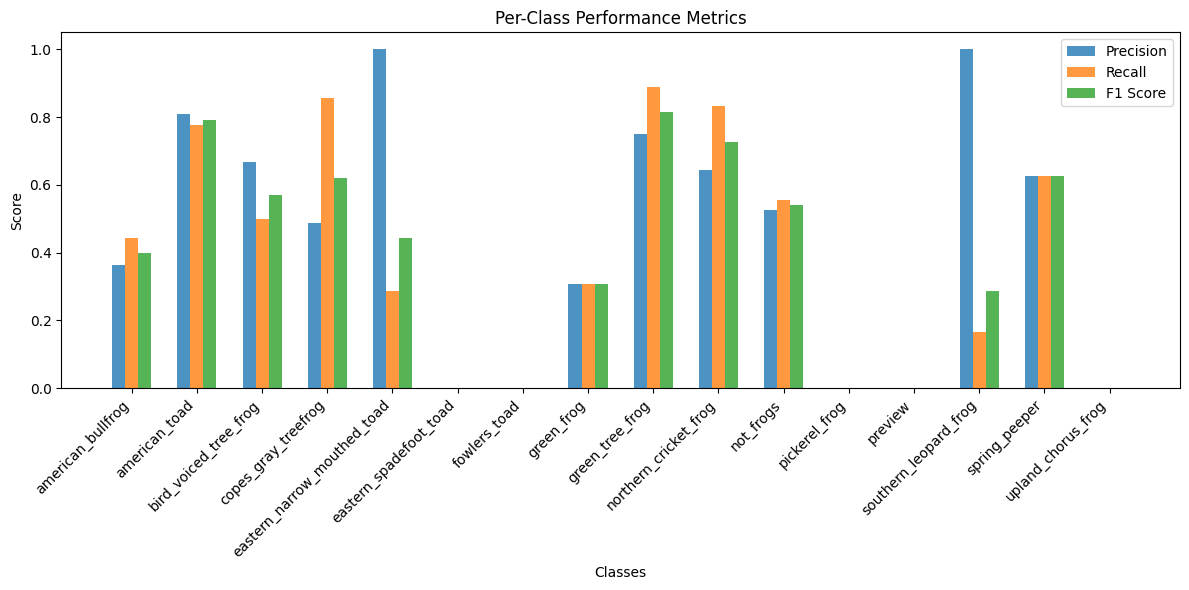

(array([0.4       , 0.79245283, 0.57142857, 0.62068966, 0.44444444,
        0.        , 0.        , 0.30769231, 0.81355932, 0.72727273,
        0.54054054, 0.        , 0.        , 0.28571429, 0.625     ,
        0.        ]),
 array([0.36363636, 0.80769231, 0.66666667, 0.48648649, 1.        ,
        0.        , 0.        , 0.30769231, 0.75      , 0.64516129,
        0.52631579, 0.        , 0.        , 1.        , 0.625     ,
        0.        ]),
 array([0.44444444, 0.77777778, 0.5       , 0.85714286, 0.28571429,
        0.        , 0.        , 0.30769231, 0.88888889, 0.83333333,
        0.55555556, 0.        , 0.        , 0.16666667, 0.625     ,
        0.        ]))

In [27]:
detailed_class_analysis(model, test_loader, device, dataset.classes)

In [ ]:
def analyze_model_performance(model, train_loader, val_loader, device):
    """Analyze model performance and predictions"""
    model.eval()

    # Training set predictions
    train_correct = 0
    train_total = 0
    train_confidences = []

    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, 1)

            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_confidences.extend(max_probs.cpu().tolist())

    train_acc = train_correct / train_total

    # Validation set predictions
    val_correct = 0
    val_total = 0
    val_confidences = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probabilities, 1)

            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_confidences.extend(max_probs.cpu().tolist())

    val_acc = val_correct / val_total

    print(f"\n📊 Model Performance Analysis:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Training Confidence - Mean: {np.mean(train_confidences):.3f}, Std: {np.std(train_confidences):.3f}")
    print(f"Validation Confidence - Mean: {np.mean(val_confidences):.3f}, Std: {np.std(val_confidences):.3f}")

    return train_acc, val_acc

# Run analysis after training
print("\n" + "="*50)
print("FINAL MODEL ANALYSIS")
print("="*50)
train_acc, val_acc = analyze_model_performance(model, train_loader, val_loader, device)


FINAL MODEL ANALYSIS

📊 Model Performance Analysis:
Training Accuracy: 0.5714
Validation Accuracy: 0.5714
Training Confidence - Mean: 0.526, Std: 0.247
Validation Confidence - Mean: 0.544, Std: 0.254


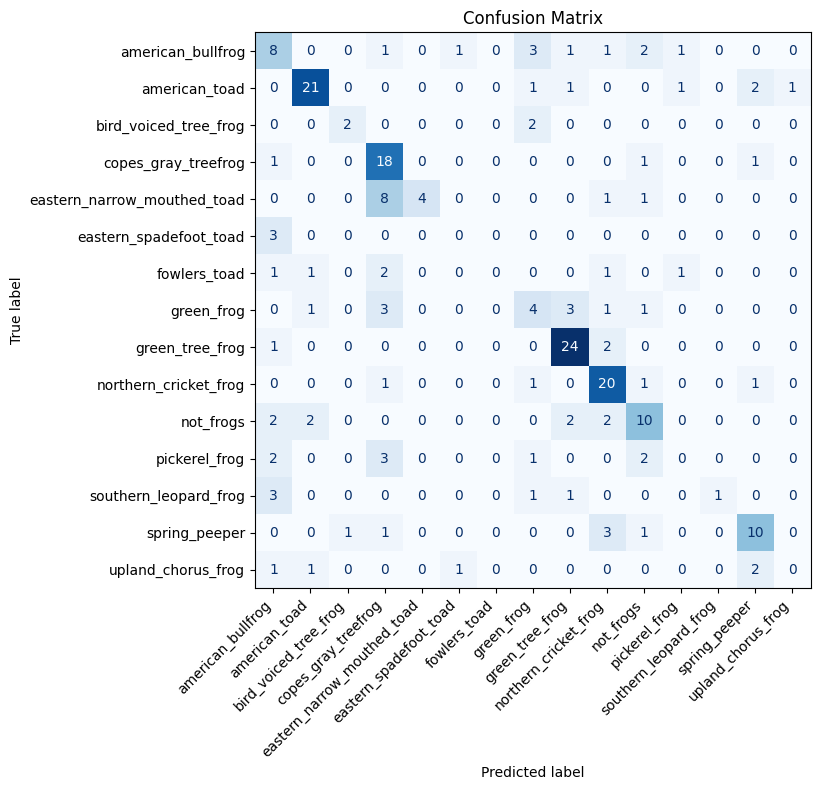

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Get unique labels from the true and predicted values
unique_labels = np.unique(np.concatenate((y_true, y_pred)))

# Generate confusion matrix using only the unique labels
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

# Get the class names corresponding to the unique labels
display_class_labels = [dataset.classes[i] for i in unique_labels]

# Create ConfusionMatrixDisplay with the confusion matrix and corresponding class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_class_labels)

# Get the axes object from the plot
fig, ax = plt.subplots(figsize=(10, 8)) # You can adjust the figure size as needed
disp.plot(ax=ax, cmap='Blues', colorbar=False) # Add cmap here

# Explicitly set ticks and labels using the display_class_labels
num_unique_classes = len(unique_labels)
ax.set_xticks(np.arange(num_unique_classes))
ax.set_yticks(np.arange(num_unique_classes))
ax.set_xticklabels(display_class_labels, rotation=45, ha="right")
ax.set_yticklabels(display_class_labels)


plt.title("Confusion Matrix")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [ ]:
print("Sample batch stats:")
images, labels = next(iter(train_loader))
print(f"Image shape: {images.shape}")
print(f"Label distribution in batch: {torch.bincount(labels)}")
print(f"Data range: [{images.min():.3f}, {images.max():.3f}]")

# Task
Explain how to push a Colab notebook to GitHub.